In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
from scipy.optimize import curve_fit

import pandas as pd

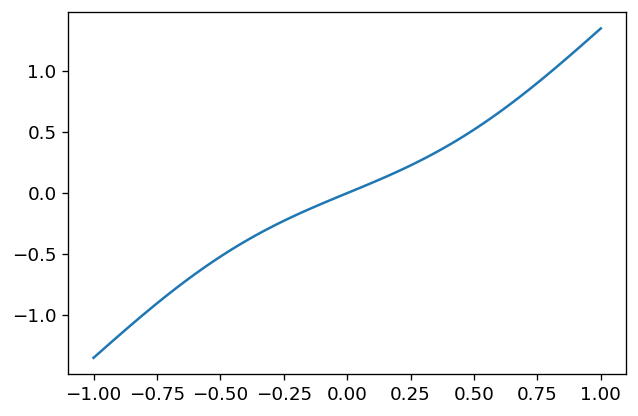

In [2]:
# Functional form of the displacement as a function of angle,
# including extra parameters for phase and displacement offsets
#d = 1.01 # In mm
n0 = 1.00029 # Weisstein Eric. Index of Refraction. Wolfram Research. 2005.

# For 4-slide sample:
#d = 4.0
#d = 2.29 # for sapphire sample
d = 5.59 # for bk7 glass slab
#d = 11.88 # Empty cuvette
#d = 11.96 # Oil cuvette
#d = .84 # Cuvette wall width

# Theta should be in radians
def func_form(theta, a0, a1, a2):
    return a0 + d*(1 - (n0 * np.cos(theta + a1))/np.sqrt(a2**2 + n0**2 * np.sin(theta + a1)**2))*np.sin(theta + a1)

testAngleArr = np.linspace(-1, 1, 100)
testDisplacementArr = [func_form(t, 0, 0, 1.6) for t in testAngleArr]

plt.plot(testAngleArr, testDisplacementArr)
plt.show()

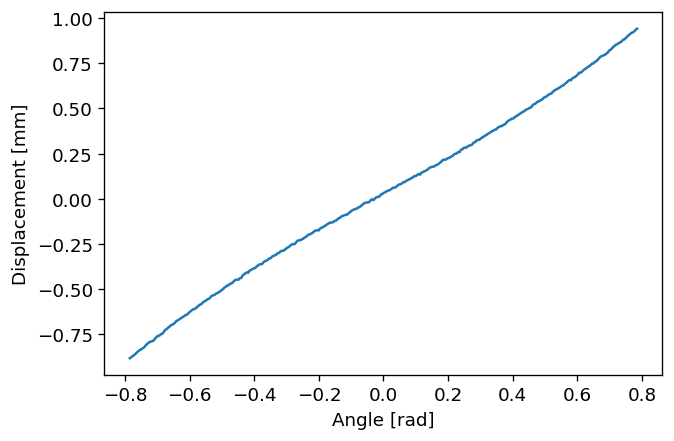

In [15]:
data = pd.read_csv('data/sapphire_disk.txt')

# Convert to radians and mm
# Not sure why I have to take the negative of the angle (horizontal reflection)
angleArr = - data["angle"] * np.pi / 180
displacementArr = data["peak_position"] * 1e-3 - np.mean(data["peak_position"] * 1e-3)
angleArr = angleArr[60:-60]
displacementArr = displacementArr[60:-60]

plt.plot(angleArr, displacementArr)
plt.ylabel('Displacement [mm]')
plt.xlabel('Angle [rad]')
#plt.savefig('images/ruby_sample.png')
plt.show()

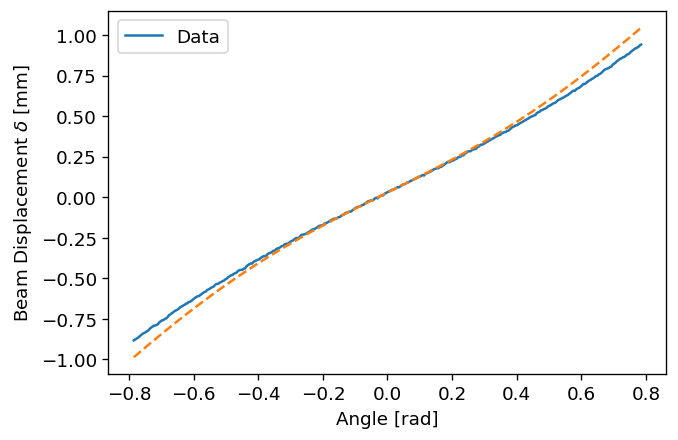

In [16]:
# Now actually do the curve fitting
popt, pcov = curve_fit(func_form, angleArr, displacementArr,
                       #method='trf',
                       # Bounds for [width, displacement offset, phase offset, IoR]
                       bounds=([-6, -np.pi/2 + .01, 1.7], # Lower bound
                               [6, np.pi/2 - .01, 1.8])) # Upper bound

plt.plot(angleArr, displacementArr, label='Data')
#plt.plot(angleArr, displacementArr - func_form(angleArr, *popt))
#plt.plot(angleArr, func_form(angleArr, *popt), '--', label='Fit')
plt.plot(angleArr, func_form(angleArr, popt[0], popt[1], 1.76), '--')
#plt.axvline(popt[1], linestyle='--', color='g')
plt.xlabel('Angle [rad]')
plt.ylabel(r'Beam Displacement $\delta$ [mm]')
plt.legend()

#print(f'Real phase difference: {phaseDiff}')
#print(f'Calculated phase difference {popt}')
#plt.savefig('images/initial_fit.png')
plt.show()

In [17]:
print(popt)

[2.84832575e-02 6.26933189e-04 1.70000000e+00]


In [48]:
nTestArr = np.linspace(1.4, 1.55, 10)
phaseOffsetArr = np.linspace(-.1, .1, 10)
offsetArr = np.linspace(-.1, .1, 10)

minResidual = 100
fn, fo, fp = 0,0,0
for n in nTestArr:
    for o in offsetArr:
        for p in phaseOffsetArr:
            testArr = np.array([func_form(t, o, p, n) for t in angleArr])
            residual = sum(abs(displacementArr - testArr))
            if residual < minResidual:
                minResidual = residual
                fn, fo, fp = n, o, p
#for i in range(len(nTestArr)):
#    for j in range(len(phaseOffsetA))
#    residualSumArr.append(sum(abs(displacementArr - testArr)))
print(n, o, p)
#plt.plot(nTestArr, residualSumArr)

1.55 0.1 0.1


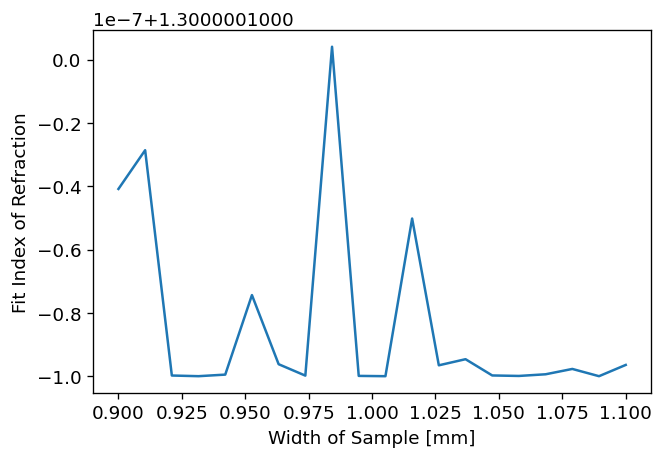

In [51]:
dArr = np.linspace(.9, 1.1, 20)

nArr = []

for d in dArr:
    popt, pcov = curve_fit(func_form, angleArr, displacementArr,
                           #method='trf',
                           # Bounds for [width, displacement offset, phase offset, IoR]
                           bounds=([-6, -np.pi/2 + .01, 1.3], # Lower bound
                                   [6, np.pi/2 - .01, 1.8])) # Upper bound
    nArr.append(popt[2])
    
plt.plot(dArr, nArr)
plt.xlabel('Width of Sample [mm]')
plt.ylabel('Fit Index of Refraction')

plt.savefig('images/width_analysis.png')
plt.show()